### Z1/Z2-only Best Circuit OED Experiment

This notebooks serves as an analysis for the Z1/Z2 Circuits OED wrapper.

In [1]:
import sys
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.integrate import odeint

# Add miner folder to path to load custom modules
sys.path.append(os.path.abspath("../circuits_miner"))

from get_system_equations_pop import system_equations_DsRed_pop
from define_circuit import Topo

print("Libraries loaded.")

Libraries loaded.


We first load the best circuit found using (modified) GCAD.

Loading results from: ../circuits_miner/results\Miner_Z1Z2_DsRed_2026-02-11
Found 2 Unique Topologies on Pareto Front.

Selected Circuit (Rank 0):
Topology: [('P1', 'Z1'), ('P1', 'I2'), ('Z1', 'Rep'), ('Z1', 'I2'), ('Z1', 'Z1'), ('I2', 'Z1'), ('I2', 'Rep')]
Nominal Doses: {'Rep': 200, 'I2': 45, 'Z1': 75}
Miner Prominence: 2.04


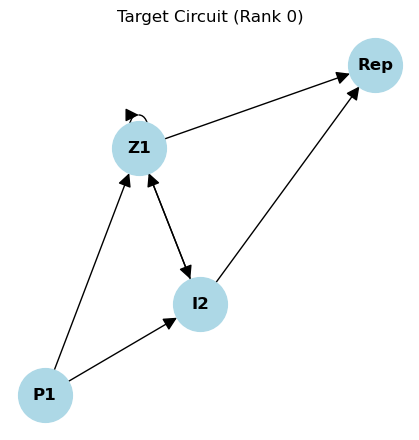

In [2]:

# 1. LOAD Z1/Z2 MINER RESULTS

# Go up one level (..), then into circuits_miner/results
MINER_RESULTS_ROOT = "../circuits_miner/results" 

# Check if path exists
if not os.path.exists(MINER_RESULTS_ROOT):
    raise FileNotFoundError(f"Could not find path: {os.path.abspath(MINER_RESULTS_ROOT)}")

# Find all run folders
all_subdirs = [
    os.path.join(MINER_RESULTS_ROOT, d) 
    for d in os.listdir(MINER_RESULTS_ROOT) 
    if os.path.isdir(os.path.join(MINER_RESULTS_ROOT, d))
]

# Filter for the Z1/Z2 runs specifically (ignore FreeSearch for now)
z1z2_runs = [d for d in all_subdirs if "Z1Z2" in d]

if not z1z2_runs:
    raise FileNotFoundError("No Z1/Z2 results found! Did you run the Z1/Z2 Miner?")

# Pick the latest one
latest_subdir = max(z1z2_runs, key=os.path.getmtime)
print(f"Loading results from: {latest_subdir}")

# Load Data
winner_pop = pd.read_pickle(f"{latest_subdir}/final_population.pkl")
winner_df = pd.read_pickle(f"{latest_subdir}/final_objectives_df.pkl")

# Fix signs (Minimization -> Maximization)
winner_df['prominence_rel'] = -winner_df['prominence_rel']
winner_df['circuit_object'] = [ind[0] for ind in winner_pop]

# Group by Unique Topology
winner_df['topology_sig'] = winner_df['circuit_object'].apply(lambda c: tuple(sorted(c.edge_list)))
unique_topos = winner_df[winner_df['prominence_rel'] > 0.1].sort_values('prominence_rel', ascending=False).groupby('topology_sig').first().reset_index()

print(f"Found {len(unique_topos)} Unique Topologies on Pareto Front.")


# 2. SELECT TARGET

# Rank 0 = The "Best" (highest prominence)
# Rank 1 = The "Runner up" (second best interms of prominence)
TARGET_RANK = 0

if TARGET_RANK >= len(unique_topos):
    print(f"Error: Rank {TARGET_RANK} out of bounds. Defaulting to 0.")
    TARGET_RANK = 0

target_row = unique_topos.iloc[TARGET_RANK]
target_circuit = target_row['circuit_object']
nominal_prom = target_row['prominence_rel']

print(f"\nSelected Circuit (Rank {TARGET_RANK}):")
print(f"Topology: {target_circuit.edge_list}")
print(f"Nominal Doses: {target_circuit.dose}")
print(f"Miner Prominence: {nominal_prom:.2f}")

# Visualize Topology
G = nx.DiGraph(target_circuit.edge_list)
pos = nx.spring_layout(G, seed=25)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_weight='bold', arrowsize=20)
plt.title(f"Target Circuit (Rank {TARGET_RANK})")
plt.show()

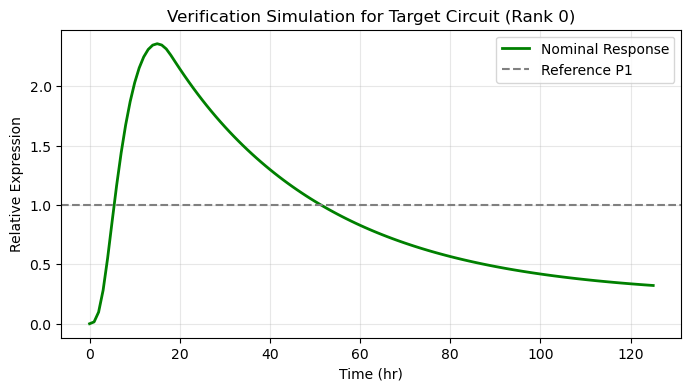

Verification Max Prominence: 2.04
SUCCESS: Circuit pulses. Proceeding to OED.


In [3]:

# VERIFICATION SIMULATION

# Load Nominal Parameters
PARTS_PATH = "../circuits_miner"

with open(f"{PARTS_PATH}/promo.pkl", "rb") as f: nominal_promo = pickle.load(f)
with open(f"{PARTS_PATH}/parts.pkl", "rb") as f: nominal_parts = pickle.load(f)
with open(f"{PARTS_PATH}/Ref.pkl", "rb") as f:   Ref_data = pickle.load(f)

# Simulation Config
t_span = np.arange(0, 126, 1)
ref_val = Ref_data[target_circuit.promo_node]['on']

# RUN SIMULATION (Using DsRed Physics)
y_nominal = odeint(
    system_equations_DsRed_pop,
    np.zeros(target_circuit.num_states * 2),
    t_span,
    args=('on', np.ones(5), target_circuit, nominal_promo, nominal_parts)
)[:, -1]

y_rel = y_nominal / (ref_val + 1e-9)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_span, y_rel, 'g-', linewidth=2, label='Nominal Response')
plt.xlabel("Time (hr)")
plt.ylabel("Relative Expression")
plt.title(f"Verification Simulation for Target Circuit (Rank {TARGET_RANK})")
plt.axhline(1.0, linestyle='--', color='gray', label='Reference P1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check Peak
prom_val = np.max(y_rel) - y_rel[-1]
print(f"Verification Max Prominence: {prom_val:.2f}")
if prom_val < 1.5:
    print("WARNING: Pulse is very weak. Check dosage or settings.")
else:
    print("SUCCESS: Circuit pulses. Proceeding to OED.")

In [4]:
# 1. EXPERIMENTAL CONFIGURATION

# File to save/load simulation data
DATA_FILE = "oed_z1z2_simulation_data_seed25.pkl"

# Simulation Parameters
N_SAMPLES = 200           # 200 Virtual Cells
PERTURBATION_SCALE = 0.2  # k=0.2 (10^0.2 ~= 1.6x variation).
SIM_TIME = 126            # Hours

# Dosage Grid
# 0.2x to 4.0x in 20 steps covers the "Starved" to "Saturated" regime
DOSAGE_SCALERS = np.linspace(0.2, 4.0, 20) # stepsize = 0.2

print("Configuration Loaded.")
print(f"Noise Scale: {PERTURBATION_SCALE} (approx +/- 60%)")
print(f"Dosage Grid: {len(DOSAGE_SCALERS)} points from {DOSAGE_SCALERS[0]:.1f}x to {DOSAGE_SCALERS[-1]:.1f}x")

Configuration Loaded.
Noise Scale: 0.2 (approx +/- 60%)
Dosage Grid: 20 points from 0.2x to 4.0x


We then generate the simulation data for the Z1/Z2 circuit with randomized parameters around the nomimal values, across a same range of dosages. (Seed fixed)


_Note: Careful to re-run_


In [5]:

# 2. DATA GENERATION ENGINE (MASTER)

def run_simulation_campaign():
    print(">> Data file not found. INITIALIZING NEW SIMULATION CAMPAIGN...")
    
    # 1. SET SEED FOR REPRODUCIBILITY
    np.random.seed(25)
    
    # 2. Load Nominal Miner Result
    miner_results_path = "../circuits_miner/results"
    all_subdirs = [
        os.path.join(miner_results_path, d) 
        for d in os.listdir(miner_results_path) 
        if "Z1Z2" in d and os.path.isdir(os.path.join(miner_results_path, d))
    ]
    
    if not all_subdirs:
        raise FileNotFoundError("No Z1/Z2 results found in ../circuits_miner/results")
        
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    
    # Load Data
    with open(f"{latest_subdir}/final_population.pkl", "rb") as f: final_pop = pickle.load(f)
    with open(f"{latest_subdir}/final_objectives_df.pkl", "rb") as f: final_df = pd.read_pickle(f)
    
    miner_path = "../circuits_miner"
    with open(f"{miner_path}/parts.pkl", "rb") as f: nominal_parts = pickle.load(f)
    with open(f"{miner_path}/promo.pkl", "rb") as f: nominal_promo = pickle.load(f)
    with open(f"{miner_path}/Ref.pkl", "rb") as f:   ref = pickle.load(f)

    # Identify Winner
    best_idx = final_df['prominence_rel'].idxmin() 
    winner_circuit = final_pop[best_idx][0]
    ref_val = ref[winner_circuit.promo_node]['on']
    
    print(f"   Loaded Winner from: {latest_subdir}")

    # 3. Generate Virtual Population
    # Sample #0 is ALWAYS Nominal
    pop_parts = [nominal_parts] 
    pop_promo = [nominal_promo] * N_SAMPLES 
    
    print("   Generating 200 Virtual Mutants...")
    
    for _ in range(N_SAMPLES - 1):
        # Perturb only Parts
        p_mut = {}
        for k, v in nominal_parts.items():
            if isinstance(v, (list, np.ndarray)):
                noise = 10 ** np.random.uniform(-PERTURBATION_SCALE, PERTURBATION_SCALE, size=len(v))
                p_mut[k] = np.array(v) * noise
            else:
                noise = 10 ** np.random.uniform(-PERTURBATION_SCALE, PERTURBATION_SCALE)
                p_mut[k] = v * noise
        pop_parts.append(p_mut)

    # 4. Run Dosage Scan
    # We save BOTH the traces AND the parameters
    data = {
        "dosages": DOSAGE_SCALERS,
        "traces": {},       # { dose: [200 traces] }
        "parameters": pop_parts, # List of 200 param dicts
        "active_nodes": list(winner_circuit.dose.keys()) # ['Z1', 'I2'] for filtering later
    }
    
    t_span = np.arange(0, SIM_TIME, 1)
    print(f"   Simulating across {len(DOSAGE_SCALERS)} dosages...")
    
    for d_scale in tqdm(DOSAGE_SCALERS):
        # Scale Doses
        scaled_dose = {k: v * d_scale for k, v in winner_circuit.dose.items() if k != 'Rep'}
        scaled_dose['Rep'] = winner_circuit.dose['Rep']
        temp_circuit = Topo(winner_circuit.edge_list, scaled_dose, winner_circuit.promo_node)
        
        current_traces = np.zeros((N_SAMPLES, len(t_span)))
        
        for i in range(N_SAMPLES):
            y = odeint(
                system_equations_DsRed_pop,
                np.zeros(temp_circuit.num_states * 2),
                t_span,
                args=('on', np.ones(5), temp_circuit, pop_promo[i], pop_parts[i])
            )[:, -1]
            current_traces[i, :] = y / (ref_val + 1e-9)
            
        data["traces"][d_scale] = current_traces

    # 5. Save Master File
    with open(DATA_FILE, "wb") as f:
        pickle.dump(data, f)
    print(f">> Data saved to {DATA_FILE}")
    
    return data

# CHECK AND LOAD
if os.path.exists(DATA_FILE):
    print(f">> Found existing data: {DATA_FILE}. Loading...")
    with open(DATA_FILE, "rb") as f:
        data = pickle.load(f)
else:
    data = run_simulation_campaign()

campaign_data = data["traces"] 


>> Found existing data: oed_z1z2_simulation_data_seed25.pkl. Loading...


Now we define the helper functions to calculate the metrics for OED.

We here use conditional variance for both `prom_rel` and `t_pulse` ($Var(Y | \text{Success})$). (filter out non-pulsing curves with the 20% criterion) because we can calculate the time variance only when there is a clear `t_pulse` (non-pulsing ones are set to have `t_pulse = max_time`)

In [6]:

# 3. METRIC DEFINITIONS

def get_pulse_metrics(trace):
    """
    Returns (Prominence, Time_to_Peak, Quality_Score)
    Quality_Score = 1.0 if good pulse, 0.0 if saturated/flat
    """
    peak_idx = np.argmax(trace)
    peak_val = trace[peak_idx]
    final_val = trace[-1]
    
    # 1. Filter: Saturation
    # Threshold: 20% drop --> Can change this based on how strict we want to be.
    # If the signal doesn't drop by at least 20% after peak, it's a step, not a pulse.
    relative_drop = (peak_val - final_val) / (peak_val + 1e-9)
    if relative_drop < 0.2: 
        return 0.0, 0.0, 0.0 # Bad pulse
    
    # 2. Filter: Boundary Peaks
    if peak_idx == 0 or peak_idx == len(trace)-1:
        return 0.0, 0.0, 0.0 # Bad pulse
        
    prominence = peak_val - final_val
    time_to_peak = peak_idx # In hours (since dt=1)
    
    return prominence, time_to_peak, 1.0 # Good pulse

def analyze_dosage(traces):
    """
    Computes variance metrics for a single dosage ensemble.
    """
    proms = []
    times = []
    valid_count = 0
    
    for trace in traces:
        p, t, q = get_pulse_metrics(trace)
        if q > 0.5: # Valid
            proms.append(p)
            times.append(t)
            valid_count += 1
            
    # If too few valid pulses (<10%), this dosage is useless (e.g. too low or too saturated)
    if valid_count < (len(traces) * 0.1):
        return 0.0, 0.0, valid_count
    
    # Calculate Variances of VALID pulses only

    var_prom = np.var(proms)
    var_time = np.var(times)
    
    return var_prom, var_time, valid_count

In [7]:

# 4. RUN ANALYSIS

param_variances = []
time_variances = []
valid_counts = []
dosages = sorted(campaign_data.keys())

for d in dosages:
    traces = campaign_data[d]
    vp, vt, vc = analyze_dosage(traces)
    param_variances.append(vp)
    time_variances.append(vt)
    valid_counts.append(vc)

# Normalize metrics for combination
# (Map 0-1 so we can sum them)
norm_vp = np.array(param_variances) / (np.max(param_variances) + 1e-9)
norm_vt = np.array(time_variances) / (np.max(time_variances) + 1e-9)

# Combined Metric (Weighted Average)
# 70% Prominence (Shape), 30% Timing
combined_score = 0.7 * norm_vp + 0.3 * norm_vt

# Identify Key Dosages
idx_max = np.argmax(combined_score)
idx_min = np.argmin(combined_score[:15]) # Min in the lower/mid range (ignore ultra-high saturation)
idx_base = np.abs(np.array(dosages) - 1.0).argmin() # Closest to 1.0x

print(f"Optimal Dosage: {dosages[idx_max]:.2f}x (Score: {combined_score[idx_max]:.2f})")
print(f"Max Prom Variance at: {dosages[np.argmax(param_variances)]:.2f}x")
print(f"Max Time Variance at: {dosages[np.argmax(time_variances)]:.2f}x")

Optimal Dosage: 1.80x (Score: 0.98)
Max Prom Variance at: 2.00x
Max Time Variance at: 1.80x


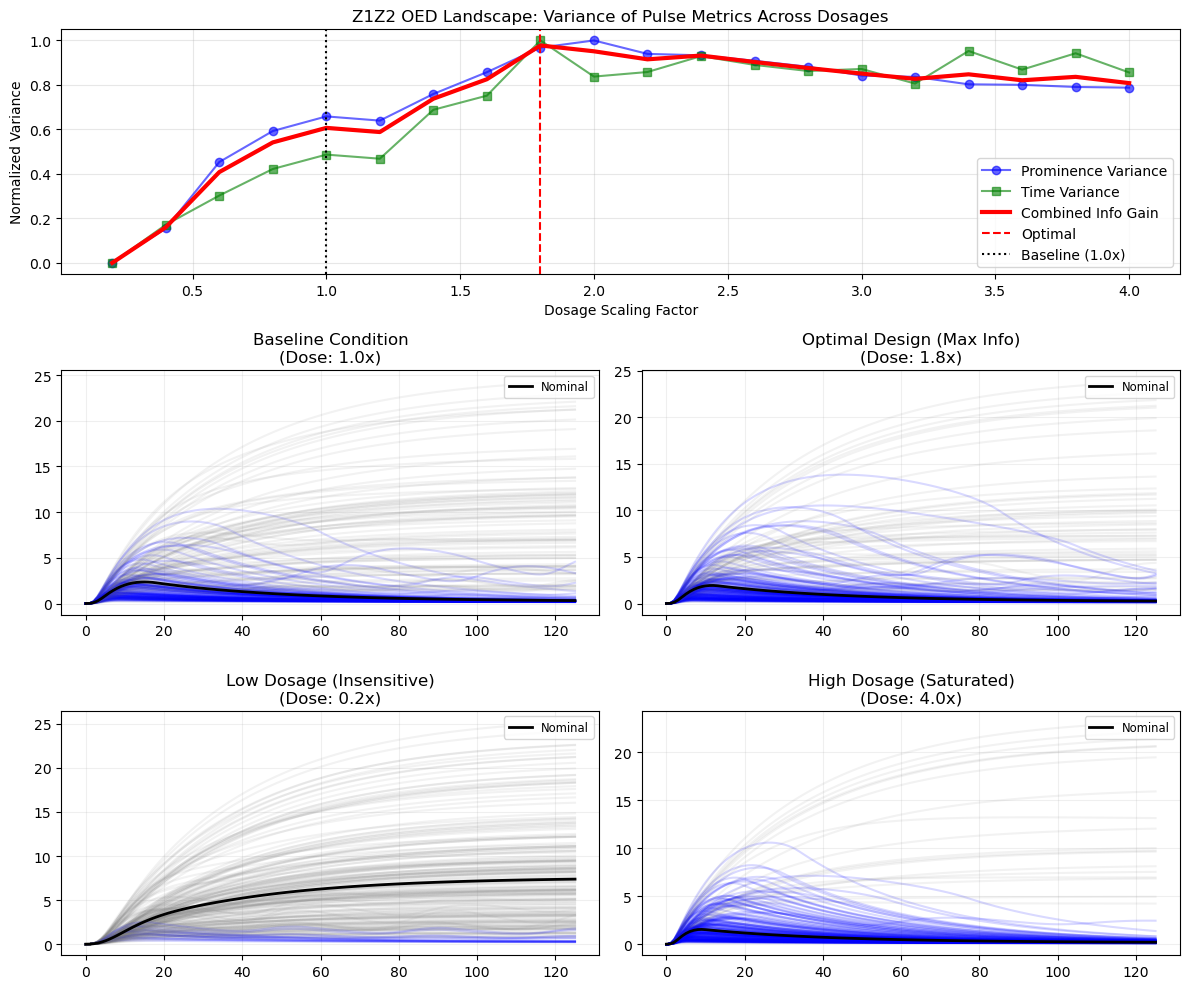

In [8]:

# 5. VISUALIZATION

fig = plt.figure(figsize=(12, 10))

# --- PLOT 1: METRICS LANDSCAPE ---
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax0.plot(dosages, norm_vp, 'b-o', label='Prominence Variance', alpha=0.6)
ax0.plot(dosages, norm_vt, 'g-s', label='Time Variance', alpha=0.6)
ax0.plot(dosages, combined_score, 'r-', linewidth=3, label='Combined Info Gain')

# Mark Key Points
ax0.axvline(dosages[idx_max], color='r', linestyle='--', label='Optimal')
ax0.axvline(1.0, color='k', linestyle=':', label='Baseline (1.0x)')

ax0.set_title("Z1Z2 OED Landscape: Variance of Pulse Metrics Across Dosages")
ax0.set_ylabel("Normalized Variance")
ax0.set_xlabel("Dosage Scaling Factor")
ax0.legend()
ax0.grid(True, alpha=0.3)

# --- PLOT 2: SPAGHETTI SUBPLOTS (2x2 Grid) ---
# Helper to plot ensemble
def plot_ensemble(ax, dose_idx, title):
    d = dosages[dose_idx]
    traces = campaign_data[d]
    t_span = np.arange(0, 126, 1)
    
    # Plot 200 traces
    for i in range(200):
        # Color based on validity?
        p, t, q = get_pulse_metrics(traces[i])
        color = 'blue' if q > 0.5 else 'gray'
        alpha = 0.15 if q > 0.5 else 0.1
        ax.plot(t_span, traces[i], color=color, alpha=alpha)
        
    # Plot Nominal (Index 0 - Thick Black)
    ax.plot(t_span, traces[0], 'k-', linewidth=2, label='Nominal')
    
    # Stats
    ax.set_title(f"{title}\n(Dose: {d:.1f}x)")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.2)

# Subplot 1: Baseline (1.0x)
ax1 = plt.subplot2grid((3, 2), (1, 0))
plot_ensemble(ax1, idx_base, "Baseline Condition")

# Subplot 2: Optimal (Max Variance)
ax2 = plt.subplot2grid((3, 2), (1, 1))
plot_ensemble(ax2, idx_max, "Optimal Design (Max Info)")

# Subplot 3: Low/Min Variance (Dead zone)
ax3 = plt.subplot2grid((3, 2), (2, 0))
plot_ensemble(ax3, 0, "Low Dosage (Insensitive)")

# Subplot 4: Saturated (High Dose)
ax4 = plt.subplot2grid((3, 2), (2, 1))
plot_ensemble(ax4, -1, "High Dosage (Saturated)")

plt.tight_layout()
plt.show()


**Notes**:

We note that the OED landscape results change moderately when we used different seeds for parameters pertubation (switch seed in the data generation step and the file path to see the difference). 

So this might suggest that we could consider explore the variance of optimal dosage? Or average optimal dosage across different set of randomized parameters?

---

Then we do some further exploration on the OED results above:

1. Sensitivity Analysis 
(Asks "Given that the circuit Pulsed (Success), what parameters did it have?")

2. Metric Review 
(Is our "Variance" metric trustworthy for measuring the information gain?)

3. Oscillatory Trace Investifation
(Whether there are oscillations or are they just late pulses?)

---

#### Part 1: Sensitivity Analysis

We want to see what are the parameters that really matter in deciding whether the design is pulsing or not.

We have 4 active parameters ($Z1_{basal}, Z1_{Vmax}, Z1_{K}, I2_{K}$) (see parts.pkl file) in this model in total.

   Analyzing parameters at Optimal Dose: 1.80x
   Feature Matrix Shape: (200, 4) (Features: ['I2_K', 'Z1_basal', 'Z1_Vmax', 'Z1_K'])
   Classification Results: 151 Pulses / 49 Failures

=== Parameter Differences ===
Label     Diff_Percent
I2_K         39.566522
Z1_Vmax      31.293236
Z1_K        -13.442492
Z1_basal     -6.512387


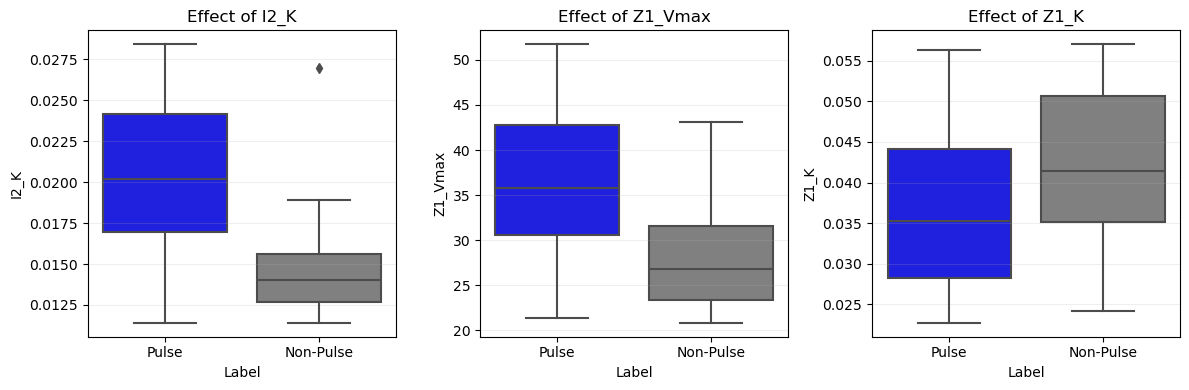

In [9]:

# Part 1: Sensitivity Forensics

import seaborn as sns


# 1. RETRIEVE DATA
if 'data' not in locals():
    # reload
    with open("oed_z1z2_simulation_data_seed25.pkl", "rb") as f:
        data = pickle.load(f)

# Use the Optimal Dosage found in previous analysis
best_idx = idx_max
opt_dose = list(data["traces"].keys())[best_idx]

print(f"   Analyzing parameters at Optimal Dose: {opt_dose:.2f}x")

raw_params_list = data["parameters"]
active_nodes = data["active_nodes"] 
traces_at_opt = data["traces"][opt_dose]

# 2. FLATTEN PARAMETERS
X_data = []
feature_names = []

for i, p_dict in enumerate(raw_params_list):
    row_values = []
    row_names = []
    
    for node in sorted(active_nodes): 
        if node in p_dict:
            vals = p_dict[node]
            # Activator (3 params) or Inhibitor (1 param)
            if len(vals) == 3: # [Basal, Vmax, K]
                row_values.extend(vals)
                if i==0: row_names.extend([f"{node}_basal", f"{node}_Vmax", f"{node}_K"])
            elif len(vals) == 1: # [K]
                row_values.extend(vals)
                if i==0: row_names.extend([f"{node}_K"])
                
    X_data.append(row_values)
    if i==0: feature_names = row_names

X = np.array(X_data)
print(f"   Feature Matrix Shape: {X.shape} (Features: {feature_names})")

# 3. CLASSIFY (Pulse vs Non-Pulse)
labels = []
for trace in traces_at_opt:
    p, t, q = get_pulse_metrics(trace)
    # same criteria as before: q > 0.5 is a valid pulse
    if q > 0.5:
        labels.append("Pulse")
    else:
        labels.append("Non-Pulse")

labels = np.array(labels)
pulse_count = np.sum(labels == 'Pulse')
print(f"   Classification Results: {pulse_count} Pulses / {len(labels) - pulse_count} Failures")

# 4. VISUALIZATION
# --- COLOR SCHEME: Blue (Success) vs Grey (Failure) ---
palette_map = {'Pulse': 'blue', 'Non-Pulse': 'grey'} 

if pulse_count > 5 and pulse_count < len(labels) - 5:

    # TOP DRIVERS & BOXPLOTS
    df_params = pd.DataFrame(X, columns=feature_names)
    df_params['Label'] = labels
    
    means = df_params.groupby('Label').mean().T
    if 'Pulse' in means.columns and 'Non-Pulse' in means.columns:
        means['Diff_Percent'] = (means['Pulse'] - means['Non-Pulse']) / means['Non-Pulse'] * 100
        top_drivers = means.reindex(means['Diff_Percent'].abs().sort_values(ascending=False).index)

        print("\n=== Parameter Differences ===")
        print(top_drivers[['Diff_Percent']])

        # Plot Top 3 Drivers
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i in range(3):
            if i < len(top_drivers):
                param = top_drivers.index[i]
                sns.boxplot(x='Label', y=param, data=df_params, ax=axes[i], palette=palette_map)
                axes[i].set_title(f"Effect of {param}")
                axes[i].grid(axis='y', alpha=0.2)
        plt.tight_layout()
        plt.show()
else:
    print("\n[!] Not enough data points in one class to run PCA/Stats.")

##### Summary of Part 1

_(Seed=25 Analysis)_ _(Note things may be different for different seed)_

* **Condition:** Optimal Dosage (1.8x).
* **Population:** 151 Functional Pulses (Blue) vs. 49 Failures (Grey).
* **Failure Mode:** The failures were **Saturated (Stuck ON)**. 


To fix the "Stuck ON" problem, the successful circuits evolved a specific three-part mechanism:

* **Stronger Repressor Binding** ( `I2_K`+39.6%): The Repressor binding affinity was increased significantly. This ensures that once the negative feedback loop engages, it is strong enough to overpower the activator and shut the pulse down.
* **Weaker Activator Binding** (`Z1_K` -13.4 %): The Activator binding affinity was *decreased*. This prevents the activator from "locking" the promoter into an ON state too easily.
* **Higher Production Activator** (`Z1_Vmax` +31%): To compensate for the weaker binding, the circuit dramatically increased the *production rate* of the Activator.

* **Non-Factor (`Z1_basal` -6.5%):** Basal leak is not a dominant driver of success or failure in this regime.
    


**Conclusion:**
The Z1/Z2 topology floods the system with a massive amount of weak-binding activator to start the pulse, but relies on a high-affinity repressor to "catch" the surge and force it back down. 

---

#### Part 2: Metric Analysis

For the second part of our baby version OED, we look closer at the metric we were using to decide the "optimal dosage" -- we used the variance of (1) `prom_rel` (2) `t_pulse` (3) weighted average of the two (7:3). 

We want to explore and examine how are the current metrics and what could be our better options.

1. We first investigate into the correlation of conditional prominence variance and conditional time variance. 

2. Then we realize that conditional variances may suffer from survival bias, so for the prominence varaince, we switch to look at unconditional variance (with invalid pulses naturally having `prom_rel = 0`), which effectively weights the metric by the reliability of the dosage. And we again see the correlation of two variances.
(But I don't think this unconditional variance would work for `t_pulse` becuase that for invalid pulse are max_time.).

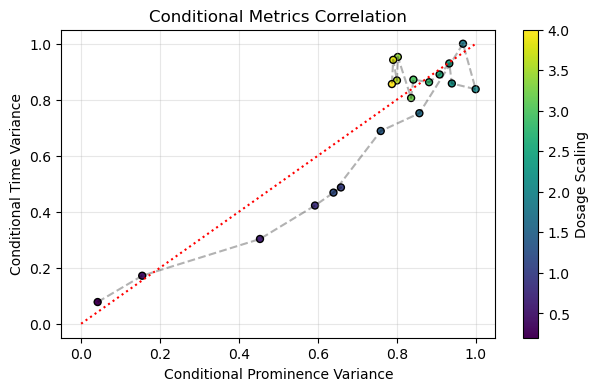

Correlation (Conditional): 0.929


In [10]:

# PART 2A: CONDITIONAL VARIANCE ANALYSIS (Baseline)

dosages = sorted(data["traces"].keys())
cond_var_p = [] # Conditional Prominence Variance
cond_var_t = [] # Conditional Time Variance

for d in dosages:
    traces = data["traces"][d]
    proms = []
    times = []
    
    # 1. Collect ONLY Valid Pulses (Conditional)
    for trace in traces:
        p, t, q = get_pulse_metrics(trace)
        if q > 0.5: 
            proms.append(p)
            times.append(t)
            
    # 2. Calculate Variance (Survival Bias Risk)
    if len(proms) > 10:
        cond_var_p.append(np.var(proms))
        cond_var_t.append(np.var(times))
    else:
        cond_var_p.append(0)
        cond_var_t.append(0)

# Normalize for Plotting
norm_cond_p = np.array(cond_var_p) / (np.max(cond_var_p) + 1e-9)
norm_cond_t = np.array(cond_var_t) / (np.max(cond_var_t) + 1e-9)

# Plot Trajectory
plt.figure(figsize=(7, 4))
sc = plt.scatter(norm_cond_p, norm_cond_t, c=dosages, cmap='viridis', s=25, edgecolors='k')
plt.plot(norm_cond_p, norm_cond_t, 'k--', alpha=0.3)
plt.plot([0, 1], [0, 1], 'r:', label='y=x')

plt.xlabel("Conditional Prominence Variance")
plt.ylabel("Conditional Time Variance")
plt.title("Conditional Metrics Correlation")
plt.colorbar(sc, label='Dosage Scaling')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation (Conditional): {np.corrcoef(norm_cond_p, norm_cond_t)[0,1]:.3f}")

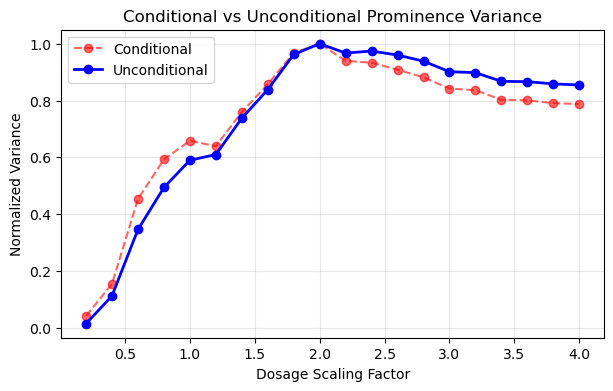

In [11]:

# PART 2B: UNCONDITIONAL VARIANCE ANALYSIS

uncond_var_p = [] # Unconditional Prominence Variance

for d in dosages:
    traces = data["traces"][d]
    all_proms = []
    
    # 1. Collect ALL Prominences (Failures = 0.0)
    for trace in traces:
        p, t, q = get_pulse_metrics(trace)
        # Even if q=0 (Failure), p is 0.0, so we append it.
        all_proms.append(p)
            
    # 2. Calculate Unconditional Variance
    uncond_var_p.append(np.var(all_proms))

# Normalize
norm_uncond_p = np.array(uncond_var_p) / (np.max(uncond_var_p) + 1e-9)

# Plot Comparison
plt.figure(figsize=(7, 4))
plt.plot(dosages, norm_cond_p, 'r--o', label='Conditional', alpha=0.6)
plt.plot(dosages, norm_uncond_p, 'b-o', label='Unconditional', linewidth=2)

plt.xlabel("Dosage Scaling Factor")
plt.ylabel("Normalized Variance")
plt.title("Conditional vs Unconditional Prominence Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

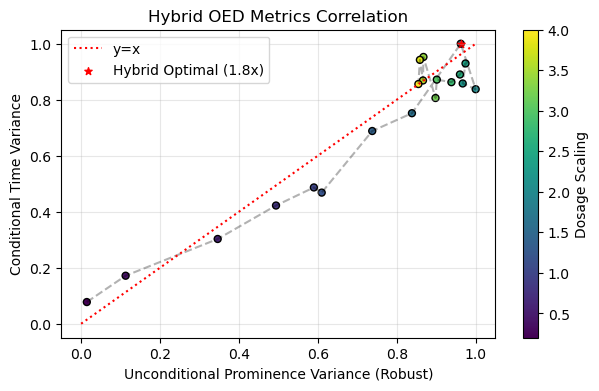

Correlation (Hybrid): 0.967
>> CONCLUSION: Even after fixing the bias, Amplitude and Time are coupled.
   The 'Optimal Dosage' is robust regardless of which metric we use.


In [12]:
# PART 2C: HYBRID CORRELATION ANALYSIS

# We correlate:
# X: Unconditional Prominence Variance (Robust to failure rate)
# Y: Conditional Time Variance (Only defined for pulses)

plt.figure(figsize=(7, 4))
sc = plt.scatter(norm_uncond_p, norm_cond_t, c=dosages, cmap='viridis', s=25, edgecolors='k')
plt.plot(norm_uncond_p, norm_cond_t, 'k--', alpha=0.3)
plt.plot([0, 1], [0, 1], 'r:', label='y=x')

# Mark the Hybrid Optimal Dosage
# (Weighted sum of Unconditional Prom + Conditional Time)
hybrid_scores = 0.7 * norm_uncond_p + 0.3 * norm_cond_t
best_idx = np.argmax(hybrid_scores)
plt.scatter(norm_uncond_p[best_idx], norm_cond_t[best_idx], c='red', marker='*', s=30, 
            label=f'Hybrid Optimal ({dosages[best_idx]:.1f}x)')

plt.xlabel("Unconditional Prominence Variance (Robust)")
plt.ylabel("Conditional Time Variance")
plt.title("Hybrid OED Metrics Correlation")
plt.colorbar(sc, label='Dosage Scaling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

corr_hybrid = np.corrcoef(norm_uncond_p, norm_cond_t)[0,1]
print(f"Correlation (Hybrid): {corr_hybrid:.3f}")

if corr_hybrid > 0.8:
    print(">> CONCLUSION: Even after fixing the bias, Amplitude and Time are coupled.")
    print("   The 'Optimal Dosage' is robust regardless of which metric we use.")

OLD Optimal Dosage (Conditional): 1.80x (Score: 0.98)
NEW Optimal Dosage (Hybrid):      1.80x (Score: 0.97)


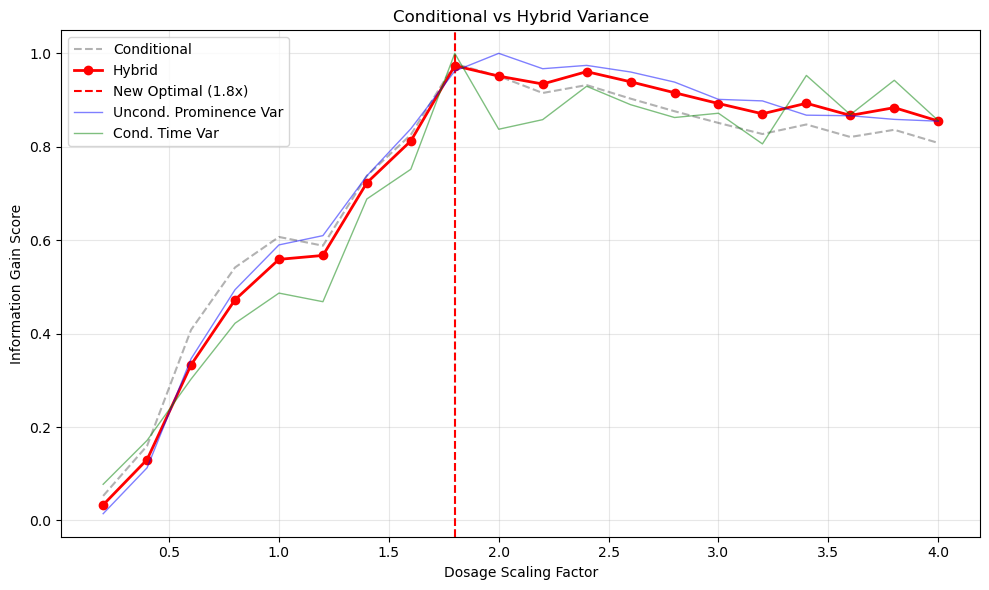

In [13]:
# HYBRID VARIANCE ANALYSIS (Conditional vs Unconditional)

# 1. DEFINE METRIC EXTRACTOR
def get_pulse_metrics(trace):
    """
    Returns (Prominence, Time_to_Peak, Quality_Score)
    Quality: 1.0 = Good Pulse, 0.0 = Failure/Saturation
    """
    peak_idx = np.argmax(trace)
    peak_val = trace[peak_idx]
    final_val = trace[-1]
    
    # Filter 1: Saturation (Must drop by 20%)
    relative_drop = (peak_val - final_val) / (peak_val + 1e-9)
    if relative_drop < 0.2: 
        return 0.0, 0.0, 0.0 # Bad
    
    # Filter 2: Boundary (Peak at start or end)
    if peak_idx == 0 or peak_idx == len(trace)-1:
        return 0.0, 0.0, 0.0 # Bad
        
    prominence = peak_val - final_val
    time_to_peak = peak_idx
    
    return prominence, time_to_peak, 1.0

# 2. RUN ANALYSIS LOOP
dosages = sorted(data["traces"].keys())

# Storage for raw variances
raw_var_p_cond = []   # Conditional Prominence Var
raw_var_p_uncond = [] # Unconditional Prominence Var
raw_var_t_cond = []   # Conditional Time Var (Time is always conditional)

for d in dosages:
    traces = data["traces"][d]
    
    # Collectors
    valid_proms = []
    all_proms = [] # Includes zeros for failures
    valid_times = []
    
    for trace in traces:
        p, t, q = get_pulse_metrics(trace)
        
        # Always add to Unconditional Prominence list
        all_proms.append(p)
        
        # Only add to Conditional lists if Valid
        if q > 0.5:
            valid_proms.append(p)
            valid_times.append(t)
            
    # Calculate Variances
    # A. Conditional Prominence (Old Way)
    if len(valid_proms) > 5:
        raw_var_p_cond.append(np.var(valid_proms))
    else:
        raw_var_p_cond.append(0.0) # Penalty for no valid pulses
        
    # B. Unconditional Prominence (New Way)
    # Variance of the WHOLE vector (including zeros)
    raw_var_p_uncond.append(np.var(all_proms))
    
    # C. Conditional Time (Always Conditional)
    if len(valid_times) > 5:
        raw_var_t_cond.append(np.var(valid_times))
    else:
        raw_var_t_cond.append(0.0)

# 3. NORMALIZE & COMBINE
# Helper for normalization
def normalize(v):
    v = np.array(v)
    return v / (np.max(v) + 1e-9)

norm_p_cond = normalize(raw_var_p_cond)
norm_p_uncond = normalize(raw_var_p_uncond)
norm_t_cond = normalize(raw_var_t_cond)

# WEIGHTS (70% Shape, 30% Timing)
score_old = 0.7 * norm_p_cond + 0.3 * norm_t_cond
score_new = 0.7 * norm_p_uncond + 0.3 * norm_t_cond

# Find Optimals
idx_old = np.argmax(score_old)
idx_new = np.argmax(score_new)

print(f"OLD Optimal Dosage (Conditional): {dosages[idx_old]:.2f}x (Score: {score_old[idx_old]:.2f})")
print(f"NEW Optimal Dosage (Hybrid):      {dosages[idx_new]:.2f}x (Score: {score_new[idx_new]:.2f})")

# 4. VISUALIZATION
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Old Strategy
ax.plot(dosages, score_old, 'k--', label='Conditional', alpha=0.3)
ax.axvline(dosages[idx_old], color='k', linestyle=':', alpha=0.3)

# Plot New Strategy
ax.plot(dosages, score_new, 'r-o', linewidth=2, label='Hybrid')
ax.axvline(dosages[idx_new], color='r', linestyle='--', label=f'New Optimal ({dosages[idx_new]:.1f}x)')

# Plot Components of New Strategy
ax.plot(dosages, norm_p_uncond, 'b-', linewidth=1, alpha=0.5, label='Uncond. Prominence Var')
ax.plot(dosages, norm_t_cond, 'g-', linewidth=1, alpha=0.5, label='Cond. Time Var')

ax.set_title("Conditional vs Hybrid Variance")
ax.set_xlabel("Dosage Scaling Factor")
ax.set_ylabel("Information Gain Score")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Summary of Part 2

We audited the metrics used to determine the "Optimal Dosage." Our goal was to ensure that our variance-based Active Learning strategy was measuring useful physical information (uncertainty), not just statistical noise.

We first analyzed the variance of *only* the valid pulses. While this showed a correlation between amplitude and timing, we realized there could be issue with survival bias. That is, A dosage where only 1% of circuits worked could artificially appear to have "High Information" simply because the few survivors were different.

To correct this, we switched to see **Unconditional Prominence Variance**, where failures essentially have prominence of `0.0`. This effectively weights the metric by the **Reliability** of the dosage. A dosage with many failures now correctly shows lower information content.

We finally check the correlation between new metrics and still find that for this Z1/Z2 topology, a dosage that reveals differences in unconditional prominence *automatically* reveals differences in pulsing time. This may prove that our optimal dosage choice is robust.

And for now, we choose to use the weighted hybrid variance as a metric of our information gain in terms of our goal of finding the dosage that maximizes the uncertainty in the parameters. In the last plot above we found that this hybrid metric gives the same result as conditional one but it loses less information.

---

#### Part 3: Oscillation Investigation

We occasionally spotted there are some oscillatory traces when I plotted all of them. Here we want to look closer into it and see whether there are truly oscillations going on -- if so, it will be VERY interesting in terms of that this means this circuit topology is capable of changing its qualitative behavior (Bifurcation) just by tweaking parameters.



   [RESULT] Scanned 4000 traces.
            Found 105 potential oscillators (3+ peaks).


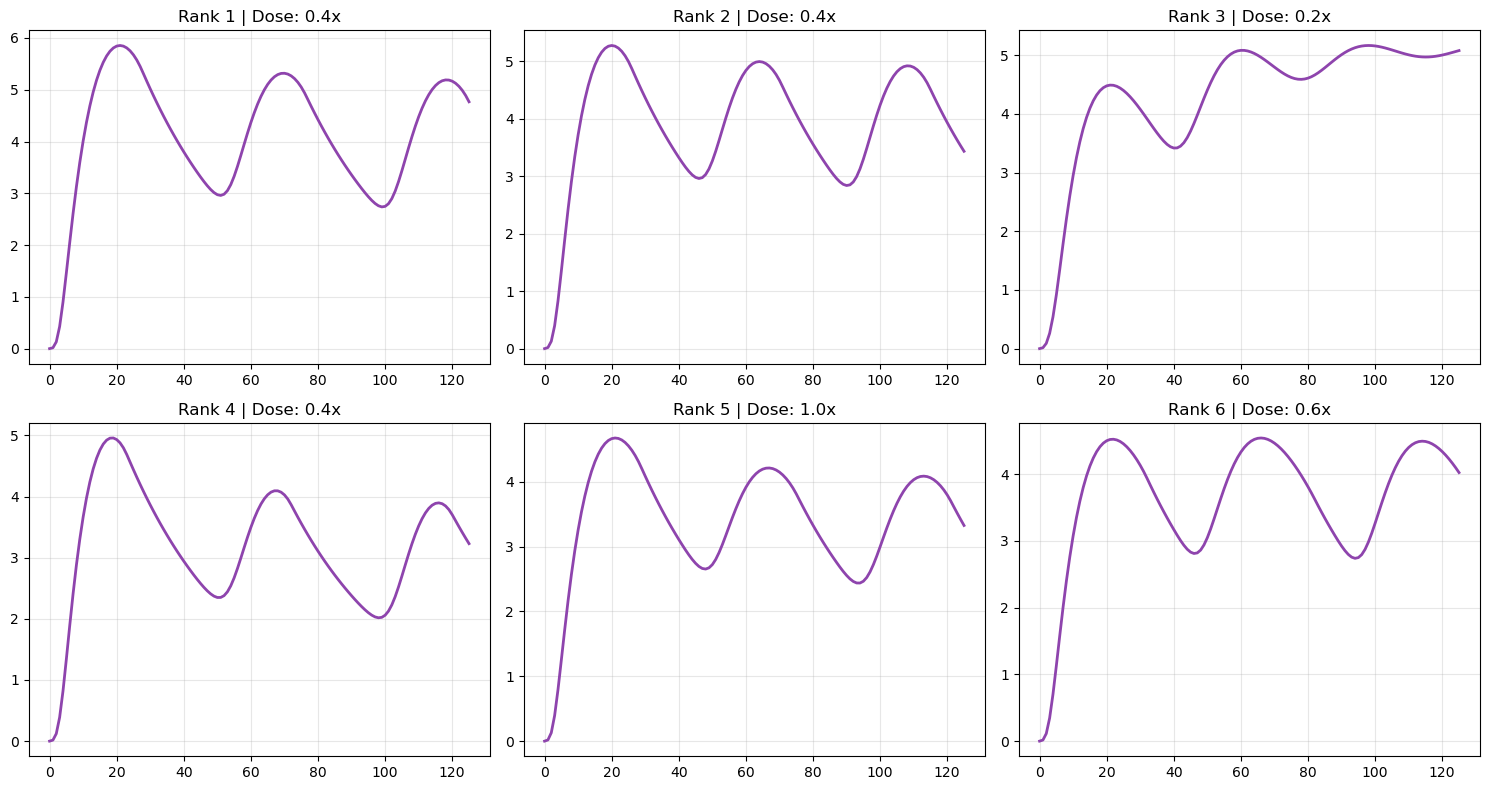

   >> Re-simulating (Mutant 65 @ 0.4x) for 500h...


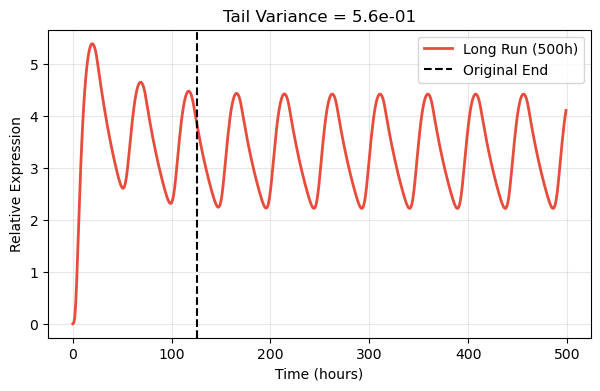

   CONFIRMED LIMIT CYCLE. The oscillation persists.


In [14]:
# 0. SETUP REFERENCE
with open(f"{latest_subdir}/final_population.pkl", "rb") as f: final_pop = pickle.load(f)
winner_circuit = final_pop[best_idx][0]

with open(f"{PARTS_PATH}/Ref.pkl", "rb") as f: Ref_data = pickle.load(f)
ref_val = Ref_data[winner_circuit.promo_node]['on']


# 1. SCAN THE ENTIRE LANDSCAPE
candidates = []
dosages = sorted(data["traces"].keys())

for dose in dosages:
    traces = data["traces"][dose]
    
    for idx, trace in enumerate(traces):
        # Find peaks with minimal prominence to catch real wobbles
        # We use strict criteria: at least 3 peaks to be an "oscillator"
        peaks, _ = find_peaks(trace, prominence=0.1, distance=10)
        
        if len(peaks) >= 3:
            # Score = Number of Peaks * Amplitude (Prioritize BIG wobbles over tiny noise)
            score = len(peaks) * (np.max(trace) - np.min(trace))
            candidates.append({
                'dose': dose,
                'idx': idx,
                'peaks': len(peaks),
                'score': score,
                'trace': trace
            })

# Sort candidates by "Wobble Score" (Descending)
candidates = sorted(candidates, key=lambda x: x['score'], reverse=True)

print(f"   [RESULT] Scanned {len(dosages)*200} traces.")
print(f"            Found {len(candidates)} potential oscillators (3+ peaks).")


# 2. VISUALIZATION (Top Candidates)
if len(candidates) > 0:
    top_candidates = candidates[:6] # Look at top 6
    
    rows = 2 if len(top_candidates) > 3 else 1
    cols = min(len(top_candidates), 3)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = np.array(axes).flatten()
    
    for i, cand in enumerate(top_candidates):
        ax = axes[i]
        ax.plot(cand['trace'], color='#8e44ad', linewidth=2)
        ax.set_title(f"Rank {i+1} | Dose: {cand['dose']:.1f}x")
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)): axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

    # 3. THE LONG RUN (Stress Test)
    # We take the #1 Top Suspect and simulate for 500 hours
    best_cand = top_candidates[0]
    idx = best_cand['idx']
    dose_factor = best_cand['dose']
    
    print(f"   >> Re-simulating (Mutant {idx} @ {dose_factor:.1f}x) for 500h...")

    # --- RECONSTRUCT CIRCUIT ---
    # Scale the dosage for this specific candidate
    scaled_dose = {k: v * dose_factor for k, v in winner_circuit.dose.items() if k != 'Rep'}
    scaled_dose['Rep'] = winner_circuit.dose['Rep']
    
    # Create temp circuit
    temp_circuit = Topo(winner_circuit.edge_list, scaled_dose, winner_circuit.promo_node)
    
    # Get Parameters
    p_mut = data["parameters"][idx]
    p_promo = data["promo_params"][idx] if "promo_params" in data else nominal_promo
    
    # Long Time Span
    t_long = np.arange(0, 500, 1)
    
    # Simulate
    y_long_raw = odeint(
        system_equations_DsRed_pop,
        np.zeros(temp_circuit.num_states * 2),
        t_long,
        args=('on', np.ones(5), temp_circuit, p_promo, p_mut)
    )[:, -1]
    
    y_long_rel = y_long_raw / (ref_val + 1e-9)
    
    # 4. PLOT VERDICT
    plt.figure(figsize=(7, 4))
    plt.plot(t_long, y_long_rel, color='#e74c3c', linewidth=2, label='Long Run (500h)')
    plt.axvline(126, color='k', linestyle='--', label='Original End')
    
    # Check Stability (Variance of last 50h)
    tail_var = np.var(y_long_rel[-50:])
    plt.title(f"Tail Variance = {tail_var:.1e}")
    plt.ylabel("Relative Expression")
    plt.xlabel("Time (hours)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if tail_var > 1e-3:
        print("   CONFIRMED LIMIT CYCLE. The oscillation persists.")
    else:
        print("   Damped Oscillation. It eventually settles.")

else:
    print("   No strong oscillators found anywhere in the landscape.")


##### **Summary of Part 3**

We scanned the entire dosage landscape (4000 traces) looking for sustained instability (3+ peaks). We found **105 potential oscillators**, a significant sub-population (~2.5%). 

We stress-tested a dosage with a set of mutant parameters and can confirm that this combination generates an oscillator here and this system may have a bifurcation point, which is **REALLY interesting**.


---

#### Time-Specific Variance Investigation

We have studied the global variance of the traces above using features extraction and we chose hybrid variance over the conditional one. This is "lossy" in terms of we throw away 99% of the curve's data to save two numbers. 

Now we want to see whether we can use time-specific variance, which looks at the raw dynamics. For EACH dosage, we are able to calculate a vector $V(t)$ (which is 126 by 1 in our context) and each entry is the variance of 200 traces at one time step.

In a nutshell: 

**variance of _features_ (Pulse Height, Pulse Timing) $\to$ variance of the _actual curves_ at every single time step $t$**

The questions now turns into how we aggregate these 20 vectors (since we have 20 dosages) into 20 "Information scores" to choose the next best dosage to do the experiment. We come up with two ideas: 

(1) Mean (Average variance per hour) -- this will pick the dosages where models disagree for a long time 

(2) Max -- this will pick dosages where models have a huge disagreement at any single point of time

As a bonus to look into time-specific variance, we can also gain some insights on when does most variance happen -- this may be helpful to decide "when to measure" in the future real lab, saving experiment time.

We will first (1) visiualize the $V(t)$ to get some taste (2) compare previous hybrid vairance vs. time-specific variance.

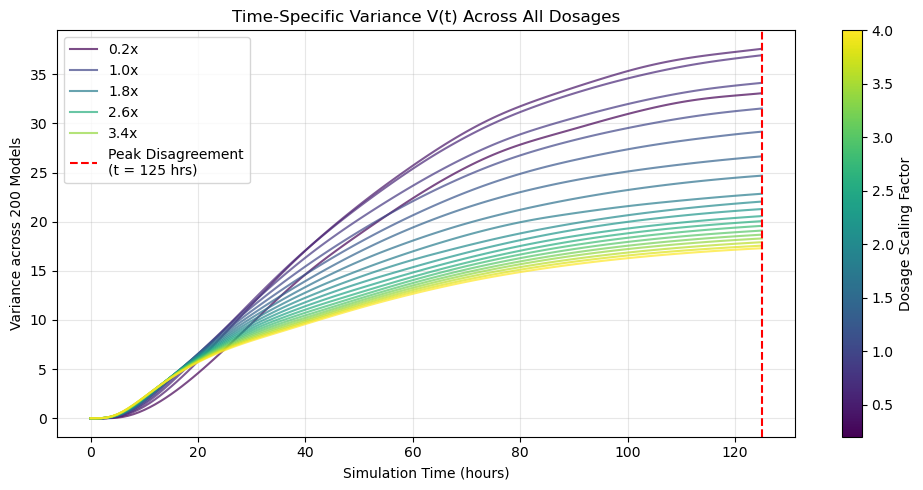

In [15]:
import matplotlib.cm as cm

dosages = sorted(data["traces"].keys())
t_span = np.arange(0, 126, 1)

# 1. CALCULATE V(t) FOR ALL DOSAGES
all_vt_curves = {}
for d in dosages:
    traces = data["traces"][d] # Shape: (200, 126)
    
    # Calculate Variance down the columns (across the 200 models at each time step)
    v_t = np.var(traces, axis=0) 
    all_vt_curves[d] = v_t

# 2. VISUALIZE V(t) LANDSCAPE
fig, ax = plt.subplots(figsize=(10, 5))
colors = cm.viridis(np.linspace(0, 1, len(dosages)))

for i, d in enumerate(dosages):
    ax.plot(t_span, all_vt_curves[d], color=colors[i], alpha=0.7, 
            label=f"{d:.1f}x" if i % 4 == 0 else "") # Only label a few to avoid crowding

# Find the absolute maximum variance point across all dosages to highlight it
max_var_overall = 0
max_t_overall = 0
for d, vt in all_vt_curves.items():
    if np.max(vt) > max_var_overall:
        max_var_overall = np.max(vt)
        max_t_overall = t_span[np.argmax(vt)]

# Highlight the Peak Disagreement Time
ax.axvline(max_t_overall, color='red', linestyle='--', 
           label=f'Peak Disagreement\n(t = {max_t_overall} hrs)')

ax.set_title("Time-Specific Variance V(t) Across All Dosages")
ax.set_xlabel("Simulation Time (hours)")
ax.set_ylabel("Variance across 200 Models")
ax.grid(True, alpha=0.3)

# Add Colorbar to show Dosage mapping
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(dosages), vmax=max(dosages)))
cbar = plt.colorbar(sm, ax=ax, label="Dosage Scaling Factor")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

=== OPTIMAL DOSAGE SELECTIONS ===
Hybrid Metric:           1.80x
Time-Specific Mean V(t): 0.40x
Time-Specific Max V(t):  0.40x


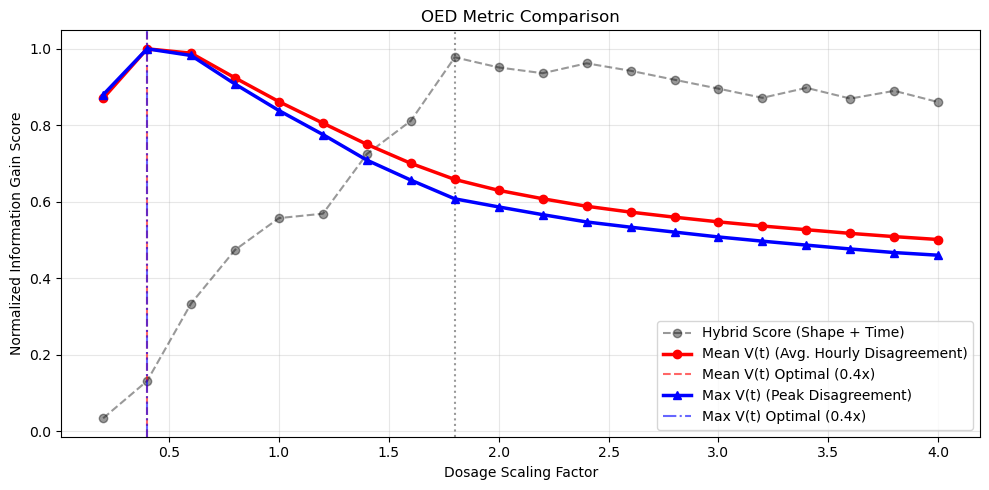

In [16]:
# METRIC COMPARISON (Hybrid vs Mean V(t) vs Max V(t))

# 1. CALCULATE TIME-SPECIFIC SCORES (Mean and Max of V(t))
raw_time_spec_mean = []
raw_time_spec_max = []

for d in dosages:
    # We use the all_vt_curves calculated above
    v_t_curve = all_vt_curves[d]
    raw_time_spec_mean.append(np.mean(v_t_curve))
    raw_time_spec_max.append(np.max(v_t_curve))

# Normalize both to 0-1 scale for comparison
norm_time_spec_mean = np.array(raw_time_spec_mean) / (np.max(raw_time_spec_mean) + 1e-9)
norm_time_spec_max = np.array(raw_time_spec_max) / (np.max(raw_time_spec_max) + 1e-9)

# 2. RE-CALCULATE HYBRID SCORE (Quickly, to ensure exact alignment)
raw_var_p_uncond = []
raw_var_t_cond = []

for d in dosages:
    traces = data["traces"][d]
    all_proms = []
    valid_times = []
    for trace in traces:
        peak_idx = np.argmax(trace)
        peak_val = trace[peak_idx]
        final_val = trace[-1]
        
        rel_drop = (peak_val - final_val) / (peak_val + 1e-9)
        q = 1.0 if (rel_drop >= 0.2 and 0 < peak_idx < len(trace)-1) else 0.0
        
        all_proms.append(peak_val - final_val)
        if q > 0.5: valid_times.append(peak_idx)
            
    raw_var_p_uncond.append(np.var(all_proms))
    raw_var_t_cond.append(np.var(valid_times) if len(valid_times) > 5 else 0.0)

norm_p_uncond = np.array(raw_var_p_uncond) / (np.max(raw_var_p_uncond) + 1e-9)
norm_t_cond = np.array(raw_var_t_cond) / (np.max(raw_var_t_cond) + 1e-9)
hybrid_score = 0.7 * norm_p_uncond + 0.3 * norm_t_cond

# 3. IDENTIFY WINNERS
idx_hybrid = np.argmax(hybrid_score)
idx_time_mean = np.argmax(norm_time_spec_mean)
idx_time_max = np.argmax(norm_time_spec_max)

print("=== OPTIMAL DOSAGE SELECTIONS ===")
print(f"Hybrid Metric:           {dosages[idx_hybrid]:.2f}x")
print(f"Time-Specific Mean V(t): {dosages[idx_time_mean]:.2f}x")
print(f"Time-Specific Max V(t):  {dosages[idx_time_max]:.2f}x")

# 4. VISUALIZE
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Hybrid (Features)
ax.plot(dosages, hybrid_score, 'k--o', label='Hybrid Score (Shape + Time)', alpha=0.4)
ax.axvline(dosages[idx_hybrid], color='k', linestyle=':', alpha=0.4)

# Plot Time-Specific MEAN
ax.plot(dosages, norm_time_spec_mean, 'r-o', linewidth=2.5, label='Mean V(t) (Avg. Hourly Disagreement)')
ax.axvline(dosages[idx_time_mean], color='r', linestyle='--', alpha=0.6, label=f'Mean V(t) Optimal ({dosages[idx_time_mean]:.1f}x)')

# Plot Time-Specific MAX
ax.plot(dosages, norm_time_spec_max, 'b-^', linewidth=2.5, label='Max V(t) (Peak Disagreement)')
ax.axvline(dosages[idx_time_max], color='b', linestyle='-.', alpha=0.6, label=f'Max V(t) Optimal ({dosages[idx_time_max]:.1f}x)')

ax.set_title("OED Metric Comparison")
ax.set_xlabel("Dosage Scaling Factor")
ax.set_ylabel("Normalized Information Gain Score")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### Conclusion: From Feature Extraction to Raw Dynamics

We performed a comparison between our previous **Hybrid Metric** (feature-based) and the new **Time-Specific Metric** (raw variance). The results reveal a fundamental difference in how we define "information":

1. **The Hybrid Metric Selected 1.8x:**
* This metric is biased by our definition of a "valid pulse." It looks for dosages where the system behaves reliably (valid pulses) but disagrees on specific traits like porminence or time.


2. **The Time-Specific Metric Selected 0.4x:**
* By removing the human bias of "features," the raw variance metric identified the **Bifurcation Point** (0.4x) we found before. This is the region where models disagree the most on the fundamental *state* of the system (Oscillation vs. Single Pulse vs. Damped).


3. **Mean vs. Max:**
* Both aggregation methods pointed to **0.4x**, confirming the result is robust.
* **Decision:** We will move forward using the **Mean Variance** ($\frac{1}{T} \sum V(t)$). This metric integrates the "total confusion" over the entire experiment duration, making it more robust to single-point noise than the Max metric.


By switching to `Mean(V(t))`, we allow the designer to "naively" search for **physical instability** rather than just parameter tuning for pulse. This is crucial for discovering complex behaviors.

**Next Step:**
We will integrate this `Mean(V(t))` metric into the our Active Learning Loop and compare the behaviors.

>> Candidate Index: 84
   Peak Value: 10.35, Relative Drop: 62.0%


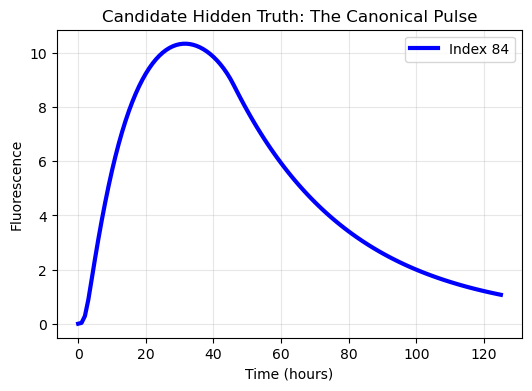

In [21]:
# We want to find another "hidden truth" with a pulse 
# to test the two metrics

target_dose = 1.7999999999999998 # We know 1.8x produces good pulses
traces_at_1_8 = data["traces"][target_dose]

best_pulse_idx = -1
best_pulse_score = -1

# We want a pulse that:
# 1. Peaks clearly in the middle (not at t=0 or t=125)
# 2. Drops almost completely back to baseline (rel_drop > 0.8)
# 3. Has a strong signal (high prominence)

for i, trace in enumerate(traces_at_1_8):
    peak_idx = np.argmax(trace)
    peak_val = trace[peak_idx]
    final_val = trace[-1]
    
    rel_drop = (peak_val - final_val) / (peak_val + 1e-9)
    
    # Strict filter for a "beautiful" pulse
    if 20 < peak_idx < 100 and rel_drop > 0.8:
        # Score it purely by how tall it is, just to get a clear signal
        if peak_val > best_pulse_score:
            best_pulse_score = peak_val
            best_pulse_idx = i

print(f">> Candidate Index: {best_pulse_idx}")
print(f"   Peak Value: {best_pulse_score:.2f}, Relative Drop: {rel_drop*100:.1f}%")

# Visualize it to make sure it looks like a good target
plt.figure(figsize=(6, 4))
t_span = np.arange(0, 126, 1)
plt.plot(t_span, traces_at_1_8[best_pulse_idx], 'b-', linewidth=3, label=f'Index {best_pulse_idx}')
plt.title("Candidate Hidden Truth: The Canonical Pulse")
plt.xlabel("Time (hours)")
plt.ylabel("Fluorescence")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()